# Strategies for Mathematical Trading

## Importing necessary libraries

In [248]:
import pandas as pd
import yfinance as yf
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

## Functions for calculation of indicator parameters

In [249]:
# https://finance.yahoo.com/news/stock-correlation-212133633.html?guccounter=1#:~:text=First%2C%20find%20the%20square%20of,each%20day%20in%20the%20period.
def corr_coef(dt1, dt2):
    return (dt1['Deviation']*dt2['Deviation']).sum()/(sqrt((dt1["Deviation"]**2).sum())*sqrt((dt2["Deviation"]**2).sum()))

In [250]:
#This function returns postive value if NSE is leading and negative if NASDAQ is leading
def lead_lag_rel(dt1, dt2, max_lag_time):
    cross_corr = [dt1.Close.corr(dt2.Close.shift(lag)) for lag in range(-max_lag_time, max_lag_time)]
    max_corr_index = cross_corr.index(max(cross_corr))

    return max(cross_corr), max_corr_index-max_lag_time

In [251]:
def calculate_keltner_channel(data, window=20, atr_win=10, atr_multiplier=2):
    # Calculate True Range (TR)
    data['H-L'] = data['High'] - data['Low']
    data['H-PC'] = abs(data['High'] - data['Close'].shift(1))
    data['L-PC'] = abs(data['Low'] - data['Close'].shift(1))
    data['TR'] = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    
    # Calculate Average True Range (ATR)
    data['ATR'] = data['TR'].ewm(atr_win).mean()
    
    # Calculate Keltner Channel
    data['KCUpperBand'] = data['Close'].ewm(window).mean() + atr_multiplier * data['ATR']
    data['KCLowerBand'] = data['Close'].ewm(window).mean() - atr_multiplier * data['ATR']
    data['KCMiddleBand'] = data['Close'].ewm(window).mean()
    
    return data[['KCUpperBand', 'KCMiddleBand', 'KCLowerBand']]

In [252]:

def calculate_bollinger_bands(data, window=20, num_std=2):
    # Calculate SMA and Standard Deviation
    sma = data['Close'].rolling(window).mean()
    std_dev = data['Close'].rolling(window).std()
    
    # Calculate Bollinger Bands
    data['BUpperBand'] = sma + num_std * std_dev
    data['BLowerBand'] = sma - num_std * std_dev
    
    return data[['BUpperBand', 'BLowerBand']]

In [253]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Calculate Exponential Moving Averages (EMA)
    ema_short = data['Close'].ewm(short_window).mean()
    ema_long = data['Close'].ewm(long_window).mean()
    
    # Calculate MACD Line
    macd_line = ema_short - ema_long
    
    # Calculate Signal Line
    signal_line = macd_line.ewm(signal_window).mean()
    
    # Calculate MACD Histogram
    macd_histogram = macd_line - signal_line
    
    data['MACD_Line'] = macd_line
    data['Signal_line'] = signal_line
    data['MACD_Histogram'] = macd_histogram
    
    return data[['MACD_Line', 'Signal_line', 'MACD_Histogram']]

In [254]:
def signal_generation(data):
    data['Keltner_Signal'] = np.where((data['Close'] > data['KCUpperBand']) & (data['Close']>data['Close'].shift(-1)), 1, np.where((data['Close'] < data['KCLowerBand']) & (data['Close']<data['Close'].shift(-1)), -1, 0))
    data['Bollinger_Signal'] = np.where((data['Close'] > data['BUpperBand']) & (data['Close']>data['Close'].shift(-1)), 1, np.where((data['Close'] < data['BLowerBand']) & (data['Close']<data['Close'].shift(-1)), -1, 0))
    
    data['MACD_Signal'] = np.where(data['MACD_Histogram'] > 0, 1, np.where(data['MACD_Histogram'] < 0, -1, 0))
    data['Returns'] = data['Close'].pct_change()
    data['MACD_Returns'] = data['Returns'] * data['MACD_Signal']
    data['Keltner_Returns'] = data['Returns'] * data['Keltner_Signal']
    data['Bollinger_Returns'] = data['Returns'] * data['Bollinger_Signal']
    return data

In [255]:
def cumulative_returns(daily_returns):
    return ((1+daily_returns/100).cumprod()-1).tail(1)*100

In [256]:
def sharpe_ratio(daily_returns):
    annualized_avg_return=daily_returns.mean()*252
    risk_free_return=[0]
    return (annualized_avg_return-risk_free_return)/(daily_returns.std()*sqrt(252))

In [257]:
def maximum_drawdown(daily_return):
    cum_max=daily_return.cummax()
    drawdowns=(daily_return-cum_max)/cum_max
    return drawdowns.min()

## Calculating parameters using data

In [258]:
data=yf.download("^IXIC", start='2010-01-01', end='2023-05-01')
dt1=pd.DataFrame(data)
data=yf.download("^NSEI", start='2010-01-01', end='2023-05-01')
dt2=pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [259]:
x_avg=dt1['Close'].mean()
dt1['Deviation']=dt1['Close']-x_avg
y_avg=dt2['Close'].mean()
dt2['Deviation']=dt2['Close']-y_avg
dt1

,Open,High,Low,Close,Adj Close,Volume,Deviation
Date,,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000,-4297.680510
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000,-4297.390471
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000,-4305.010344
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000,-4306.050383
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000,-4288.930510
...,...,...,...,...,...,...,...
2023-04-24,12053.469727,12103.580078,11960.299805,12037.200195,12037.200195,4854050000,5431.099763
2023-04-25,11968.809570,11990.459961,11798.769531,11799.160156,11799.160156,4806020000,5193.059724
2023-04-26,11913.230469,11967.990234,11833.070312,11854.349609,11854.349609,5281970000,5248.249177


In [260]:
corr_coef(dt1, dt2)

0.9142835706140554

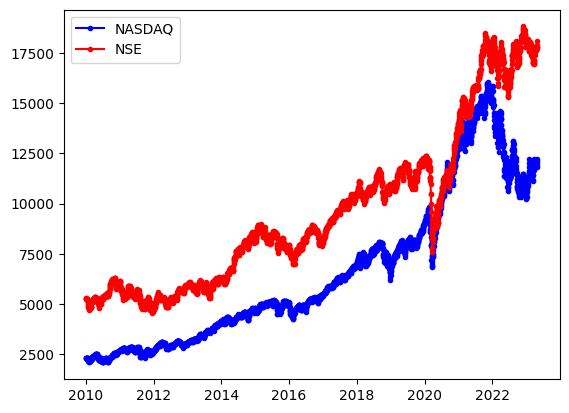

In [261]:
plt.plot(dt1.Close, '-b.', label='NASDAQ')
plt.plot(dt2.Close, '-r.', label='NSE')
plt.legend()

In [262]:
# tells us after a lag of how many days correlation maximises
# negative lag indicates NASDAQ is leading, positive indicates NSE is leading
lead_lag_rel(dt1, dt2, 200)

(0.9673330304839068, -150)

In [295]:
calculate_keltner_channel(dt1)

,KCUpperBand,KCMiddleBand,KCLowerBand
Date,,,
2010-01-04,2341.899902,2308.419922,2274.939941
2010-01-05,2343.483564,2308.568478,2273.653393
2010-01-06,2341.550039,2305.953117,2270.356196
2010-01-07,2338.978941,2304.367655,2269.756369
2010-01-08,2346.440053,2307.183847,2267.927640
...,...,...,...
2023-04-24,12192.440152,11863.514000,11534.587848
2023-04-25,12202.824335,11860.449531,11518.074727
2023-04-26,12202.105259,11860.159059,11518.212859


In [283]:
calculate_bollinger_bands(dt1)

,BUpperBand,BLowerBand
Date,,
2010-01-04,NaN,NaN
2010-01-05,NaN,NaN
2010-01-06,NaN,NaN
2010-01-07,NaN,NaN
2010-01-08,NaN,NaN
2010-01-11,NaN,NaN
2010-01-12,NaN,NaN
2010-01-13,NaN,NaN
2010-01-14,NaN,NaN


In [265]:
calculate_macd(dt1)

,Open,High,Low,Close,Adj Close,Volume,Deviation,H-L,H-PC,L-PC,TR,ATR,KCUpperBand,KCLowerBand,KCMiddleBand,BUpperBand,BLowerBand,MACD_Line,Signal_line,MACD_Histogram
Date,,,,,,,,,,,,,,,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000,-4297.680510,16.739990,NaN,NaN,16.739990,16.739990,2341.899902,2274.939941,2308.419922,NaN,NaN,0.000000,0.000000,0.000000
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000,-4297.390471,18.109863,5.310059,12.799805,18.109863,17.457543,2343.483564,2273.653393,2308.568478,NaN,NaN,0.003065,0.001613,0.001452
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000,-4305.010344,18.390137,5.360107,13.030029,18.390137,17.798461,2341.550039,2270.356196,2305.953117,NaN,NaN,-0.105355,-0.037859,-0.067496
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000,-4306.050383,16.080078,0.209961,15.870117,16.080078,17.305643,2338.978941,2269.756369,2304.367655,NaN,NaN,-0.173279,-0.077236,-0.096043
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000,-4288.930510,26.989990,17.550049,9.439941,26.989990,19.628103,2346.440053,2267.927640,2307.183847,NaN,NaN,0.094868,-0.035210,0.130077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,12053.469727,12103.580078,11960.299805,12037.200195,12037.200195,4854050000,5431.099763,143.280273,31.120117,112.160156,143.280273,164.463076,12192.440152,11534.587848,11863.514000,12316.892530,11785.111473,186.992016,175.308338,11.683678
2023-04-25,11968.809570,11990.459961,11798.769531,11799.160156,11799.160156,4806020000,5193.059724,191.690430,46.740234,238.430664,238.430664,171.187402,12202.824335,11518.074727,11860.449531,12311.900802,11793.135233,172.987823,175.076286,-2.088463
2023-04-26,11913.230469,11967.990234,11833.070312,11854.349609,11854.349609,5281970000,5248.249177,134.919922,168.830078,33.910156,168.830078,170.973100,12202.105259,11518.212859,11860.159059,12286.403134,11832.459854,162.248098,173.793468,-11.545369


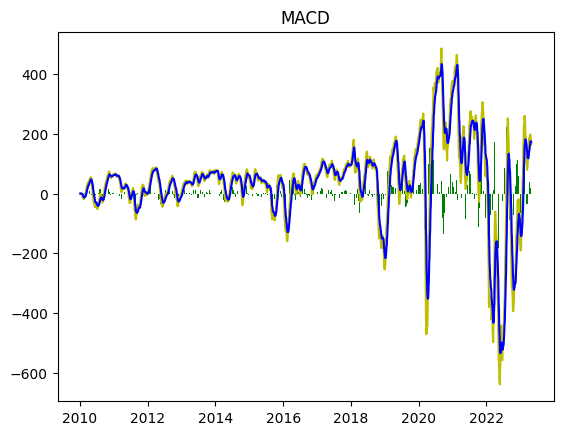

In [266]:
plt.plot(dt1['MACD_Line'], '-y')
plt.plot(dt1['Signal_line'], '-b', label='')
plt.bar(dt1.index, dt1['MACD_Histogram'], color='green', label='MACD Histogram')
plt.title('MACD')
plt.show()


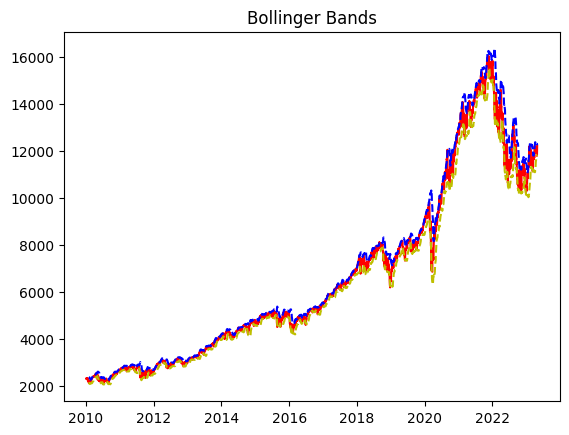

In [296]:
plt.plot(dt1['Close'], '-r')
plt.plot(dt1['BLowerBand'], '--y')
plt.plot(dt1['BUpperBand'], '--b')
plt.title('Bollinger Bands')
plt.show()

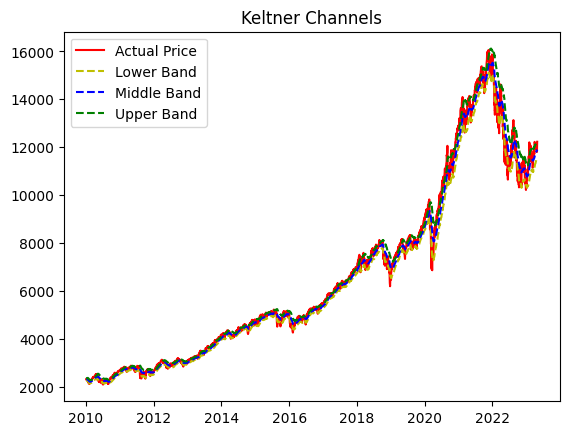

In [297]:
plt.plot(dt1['Close'], '-r', label='Actual Price')
plt.plot(dt1['KCLowerBand'], '--y', label='Lower Band')
plt.plot(dt1['KCMiddleBand'], '--b', label='Middle Band')
plt.plot(dt1['KCUpperBand'], '--g', label='Upper Band')
plt.title('Keltner Channels')
plt.legend()
plt.show()

In [298]:
signal_generation(dt1)

,Open,High,Low,Close,Adj Close,Volume,Deviation,H-L,H-PC,L-PC,...,MACD_Line,Signal_line,MACD_Histogram,Keltner_Signal,Bollinger_Signal,MACD_Signal,Returns,MACD_Returns,Keltner_Returns,Bollinger_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000,-4297.680510,16.739990,NaN,NaN,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000,-4297.390471,18.109863,5.310059,12.799805,...,0.003065,0.001613,0.001452,0,0,1,0.000126,0.000126,0.0,0.0
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000,-4305.010344,18.390137,5.360107,13.030029,...,-0.105355,-0.037859,-0.067496,0,0,-1,-0.003300,0.003300,-0.0,-0.0
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000,-4306.050383,16.080078,0.209961,15.870117,...,-0.173279,-0.077236,-0.096043,0,0,-1,-0.000452,0.000452,-0.0,-0.0
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000,-4288.930510,26.989990,17.550049,9.439941,...,0.094868,-0.035210,0.130077,0,0,1,0.007443,0.007443,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,12053.469727,12103.580078,11960.299805,12037.200195,12037.200195,4854050000,5431.099763,143.280273,31.120117,112.160156,...,186.992016,175.308338,11.683678,0,0,1,-0.002921,-0.002921,-0.0,-0.0
2023-04-25,11968.809570,11990.459961,11798.769531,11799.160156,11799.160156,4806020000,5193.059724,191.690430,46.740234,238.430664,...,172.987823,175.076286,-2.088463,0,0,-1,-0.019775,0.019775,-0.0,-0.0
2023-04-26,11913.230469,11967.990234,11833.070312,11854.349609,11854.349609,5281970000,5248.249177,134.919922,168.830078,33.910156,...,162.248098,173.793468,-11.545369,0,0,-1,0.004677,-0.004677,0.0,0.0


In [299]:
cumulative_returns(dt1['Keltner_Returns']*100)

Date
2023-04-28    3358.574302
Name: Keltner_Returns, dtype: float64

In [300]:
sharpe_ratio(dt1['Bollinger_Returns'])

array([2.36991276])

In [301]:
maximum_drawdown(dt1['Bollinger_Returns'])

-1.20116421597082

In [302]:
calculate_keltner_channel(dt2)
calculate_bollinger_bands(dt2)
calculate_macd(dt2)
signal_generation(dt2)
dt2.head(10)

,Open,High,Low,Close,Adj Close,Volume,Deviation,H-L,H-PC,L-PC,...,MACD_Line,Signal_line,MACD_Histogram,Keltner_Signal,Bollinger_Signal,MACD_Signal,Returns,MACD_Returns,Keltner_Returns,Bollinger_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0,-4369.713088,71.350098,NaN,NaN,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0,-4324.013381,45.950195,56.149902,10.199707,...,0.482865,0.254139,0.228725,0,0,1,0.008734,0.008734,0.0,0.0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0,-4320.113478,50.800293,32.950195,17.850098,...,0.686583,0.413713,0.272870,0,0,1,0.000739,0.000739,0.0,0.0
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0,-4338.813185,57.799805,20.750000,37.049805,...,0.469364,0.429895,0.039469,0,0,1,-0.003540,-0.003540,-0.0,-0.0
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0,-4357.163283,42.049805,13.649902,28.399902,...,0.012787,0.328040,-0.315253,0,0,-1,-0.003487,0.003487,-0.0,-0.0
2010-01-11,5263.799805,5287.200195,5227.799805,5249.399902,5249.399902,0,-4352.513381,59.400391,42.450195,16.950195,...,-0.190483,0.217377,-0.407859,0,0,-1,0.000887,-0.000887,0.0,0.0
2010-01-12,5251.100098,5300.500000,5200.950195,5210.399902,5210.399902,0,-4391.513381,99.549805,51.100098,48.449707,...,-1.099954,-0.035129,-1.064825,0,0,-1,-0.007429,0.007429,-0.0,-0.0
2010-01-13,5212.600098,5239.200195,5169.549805,5233.950195,5233.950195,0,-4367.963088,69.650391,28.800293,40.850098,...,-1.260326,-0.250252,-1.010074,0,0,-1,0.004520,-0.004520,0.0,0.0
2010-01-14,5234.500000,5272.850098,5232.500000,5259.899902,5259.899902,0,-4342.013381,40.350098,38.899902,1.450195,...,-0.821517,-0.343508,-0.478009,0,0,-1,0.004958,-0.004958,0.0,0.0


In [277]:
print(cumulative_returns(dt2['MACD_Returns']*100))
print(sharpe_ratio(dt2['Keltner_Returns']))
print(maximum_drawdown(dt2['Keltner_Returns']))

Date
2023-04-28    375.772099
Name: MACD_Returns, dtype: float64
[2.38349741]
-2.126549947766876
